<a href="https://colab.research.google.com/github/parlakfatma/NMA/blob/main/Copy_of_load_hcp_task_with_behaviour_depression.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Load HCP parcellated task data
## (version with Behavioural Data)

The HCP dataset comprises task-based fMRI from a large sample of human subjects. The NMA-curated dataset includes time series data that has been preprocessed and spatially-downsampled by aggregating within 360 regions of interest.

In order to use this dataset, please electronically sign the HCP data use terms at [ConnectomeDB](https://db.humanconnectome.org). Instructions for this are on pp. 24-25 of the [HCP Reference Manual](https://www.humanconnectome.org/storage/app/media/documentation/s1200/HCP_S1200_Release_Reference_Manual.pdf).

In this notebook, NMA provides code for downloading the data and doing some basic visualisation and processing.

In [ ]:
# @title Install dependencies
!pip install nilearn --quiet

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 10.6/10.6 MB 106.7 MB/s eta 0:00:00


In [ ]:
import os
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

In [ ]:
#@title Figure settings
%matplotlib inline
%config InlineBackend.figure_format = 'retina'
plt.style.use("https://raw.githubusercontent.com/NeuromatchAcademy/course-content/main/nma.mplstyle")

In [ ]:
# The data shared for NMA projects is a subset of the full HCP dataset
N_SUBJECTS = 100

# The data have already been aggregated into ROIs from the Glasser parcellation
"""
The fMRI voxel-level data have been averaged within regions of interest (ROIs) defined by the Glasser atlas, a fine-grained cortical parcellation.
The Glasser atlas divides the cerebral cortex into 360 distinct areas, with 180 regions in the right hemisphere and 180 in the left.
In this analysis, these 360 ROIs (or parcels) serve as the feature dimensions.
"""
N_PARCELS = 360

# The acquisition parameters for all tasks were identical
TR = 0.72  # Time resolution, in seconds

# The parcels are matched across hemispheres with the same order
HEMIS = ["Right", "Left"]

# Each experiment was repeated twice in each subject
RUNS   = ['LR','RL']
N_RUNS = 2

# There are 7 tasks. Each has a number of 'conditions'
# TIP: look inside the data folders for more fine-graned conditions

EXPERIMENTS = {
    'MOTOR'      : {'cond':['lf','rf','lh','rh','t','cue']},
    'WM'         : {'cond':['0bk_body','0bk_faces','0bk_places','0bk_tools','2bk_body','2bk_faces','2bk_places','2bk_tools']},
    'EMOTION'    : {'cond':['fear','neut']},
    'GAMBLING'   : {'cond':['loss','win']},
    'LANGUAGE'   : {'cond':['math','story']},
    'RELATIONAL' : {'cond':['match','relation']},
    'SOCIAL'     : {'cond':['ment','rnd']}
}

> For a detailed description of the tasks have a look pages 45-54 of the [HCP reference manual](https://www.humanconnectome.org/storage/app/media/documentation/s1200/HCP_S1200_Release_Reference_Manual.pdf).

# Downloading data

The task data are shared in different files, but they will unpack into the same directory structure.


In [ ]:
# @title Download data file
import os, requests

fname = "hcp_task.tgz"
url = "https://osf.io/2y3fw/download"

if not os.path.isfile(fname):
  try:
    r = requests.get(url)
  except requests.ConnectionError:
    print("!!! Failed to download data !!!")
  else:
    if r.status_code != requests.codes.ok:
      print("!!! Failed to download data !!!")
    else:
      with open(fname, "wb") as fid:
        fid.write(r.content)

In [ ]:
# The download cells will store the data in nested directories starting here:
HCP_DIR = "./hcp_task"

# importing the "tarfile" module
import tarfile

# open file
with tarfile.open(fname) as tfile:
  # extracting file
  tfile.extractall('.')

subjects = np.loadtxt(os.path.join(HCP_DIR, 'subjects_list.txt'), dtype='str')

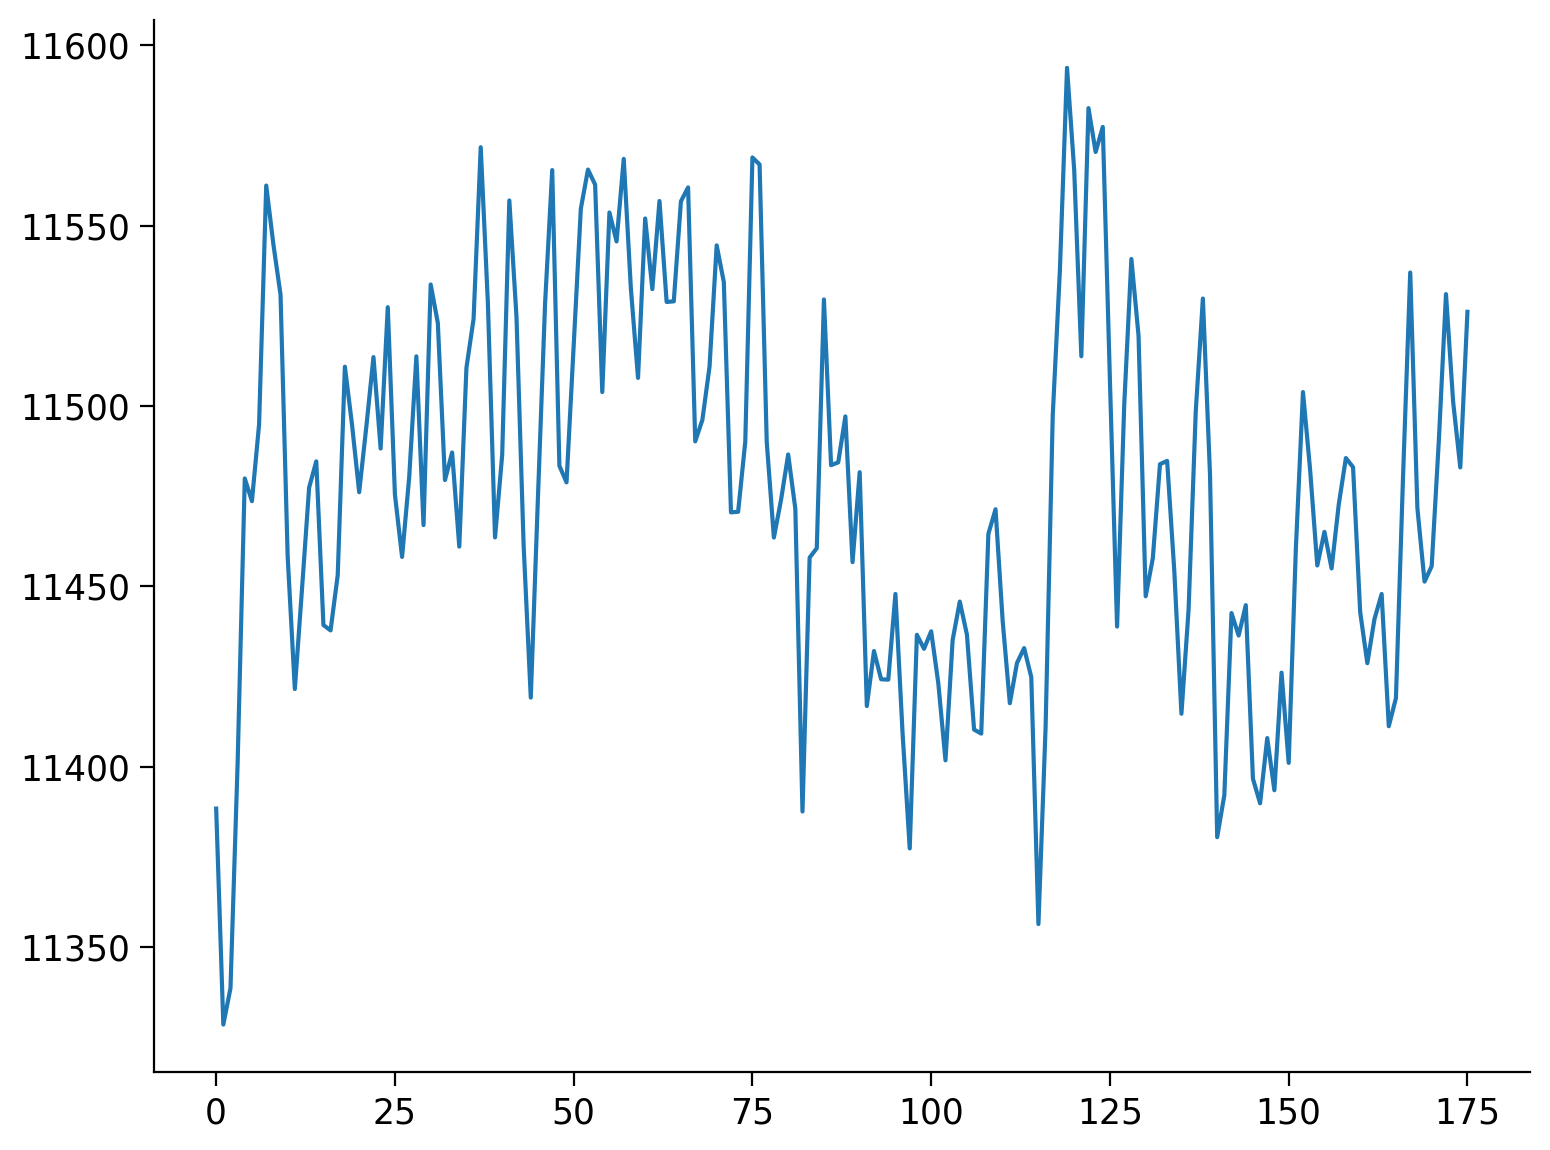

In [ ]:
emotion_data = np.load("/content/hcp_task/subjects/100307/EMOTION/tfMRI_EMOTION_LR/data.npy")
emotion_data.shape
plt.plot(emotion_data[0,:]) # BOLD response for the first parcel across time Parcel x Time
# some similarity measure between emotion and gambling
# FC matrices -- try to understand this
# for emotion - get a FC matrix parcel x parcel
# for gambling same thing
# two FC matrices look at the similarities across parcels
# read emotion tasks to understand what is their measure?
#

## Understanding the folder organisation

The data folder has the following organisation:

- hcp
  - regions.npy (information on the brain parcellation)
  - subjects_list.txt (list of subject IDs)
  - subjects (main data folder)
    - [subjectID] (subject-specific subfolder)
      - EXPERIMENT (one folder per experiment)
        - RUN (one folder per run)
          - data.npy (the parcellated time series data)
          - EVs (EVs folder)
            - [ev1.txt] (one file per condition)
            - [ev2.txt]
            - Stats.txt (behavioural data [where available] - averaged per run)
            - Sync.txt (ignore this file)



## Loading region information

Downloading this dataset will create the `regions.npy` file, which contains the region name and network assignment for each parcel.

Detailed information about the name used for each region is provided [in the Supplement](https://static-content.springer.com/esm/art%3A10.1038%2Fnature18933/MediaObjects/41586_2016_BFnature18933_MOESM330_ESM.pdf) to [Glasser et al. 2016](https://www.nature.com/articles/nature18933).

Information about the network parcellation is provided in [Ji et al, 2019](https://www.ncbi.nlm.nih.gov/pmc/articles/PMC6289683/).



In [ ]:
regions = np.load(f"{HCP_DIR}/regions.npy").T
region_info = dict(
    name=regions[0].tolist(),
    network=regions[1],
    hemi=['Right']*int(N_PARCELS/2) + ['Left']*int(N_PARCELS/2),
)

In [ ]:
my_exp = 'GAMBLING'
my_subj = subjects[1]
my_run = 1

data = load_single_timeseries(subject=my_subj,
                              experiment=my_exp,
                              run=my_run,
                              remove_mean=True)
print(data.shape)

print(data)

(360, 253)
[[  96.92568398   42.9104573   -25.92537224 ...   14.85355733
   -10.60187692  -23.67831372]
 [  42.32021174   17.83992288  -60.90614517 ...   16.72091075
   -17.91079669   -6.03204464]
 [ 257.99338772  148.00728984  146.58572448 ...   44.52077117
   -25.5371636     5.41089598]
 ...
 [  69.17104948    4.87477544   24.56660236 ...   42.77440735
   -33.76188321  -88.64388441]
 [ 127.77893856  104.57819394   55.81105832 ...  -23.07472965
    17.83709744   68.28170041]
 [ 258.30625996  221.02743452  129.22076023 ... -281.21668926
  -233.42899058 -282.28865182]]


In [ ]:
import glob
from scipy import stats
import random
import glob

# Help functions


In [ ]:
def generate_csv_list(path):
    fn_list = glob.glob(path+'/*')
    return fn_list

def read_mats(fn_list):
    """
    Accepts list of csv file names where each csv contains a single subject FC matrix
    Returns stacked matrices
    """
    fns = [pd.read_csv(fn, header=None) for fn in fn_list]
    fns = [df.dropna(axis=1).values for df in fns]
    fn_mats = np.stack(fns, axis=2)
    return fn_mats


def train_cpm(ipmat, pheno):

    """
    Accepts input matrices and pheno data
    Returns model
    @author: David O'Connor
    @documentation: Javid Dadashkarimi
    cpm: in cpm we select the most significant edges for subjects. so each subject
         have a pair set of edges with positive and negative correlation with behavioral subjects.
         It's important to keep both set in final regression task.
    posedges: positive edges are a set of edges have positive
              correlatin with behavioral measures
    negedges: negative edges are a set of edges have negative
              correlation with behavioral measures
    """

    cc=[stats.pearsonr(pheno,im) for im in ipmat]
    rmat=np.array([c[0] for c in cc])
    pmat=np.array([c[1] for c in cc])
    ##rmat=np.reshape(rmat,[360,360])
    ##pmat=np.reshape(pmat,[360,360])
    posedges=(rmat > 0) & (pmat < 0.05)
    posedges=posedges.astype(int)
    negedges=(rmat < 0) & (pmat < 0.05)
    negedges=negedges.astype(int)
    pe=ipmat[posedges.flatten().astype(bool),:]
    ne=ipmat[negedges.flatten().astype(bool),:]
    pe=pe.sum(axis=0)/2
    ne=ne.sum(axis=0)/2


    if np.sum(pe) != 0:
        fit_pos=np.polyfit(pe,pheno,1)
    else:
        fit_pos=[]

    if np.sum(ne) != 0:
        fit_neg=np.polyfit(ne,pheno,1)
    else:
        fit_neg=[]

    return fit_pos,fit_neg,posedges,negedges


def kfold_cpm(X,y,k):
    """
    Accepts input matrices and pheno data
    Returns model
    Use "run_validate" instead
    @author: David O'Connor
    @documentation: Javid Dadashkarimi
    X: is the input matrix in v*n which v is number of nodes and n is the number of subjects
    y: is the gold data which is fluid intelligence
    k: is the size of folds in k-fold
    """

    numsubs = X.shape[1]
    randinds=np.arange(0,numsubs)
    random.shuffle(randinds)

    samplesize=int(np.floor(float(numsubs)/k))

    behav_pred_pos=np.zeros([k,samplesize])
    behav_pred_neg=np.zeros([k,samplesize])

    behav_actual=np.zeros([k,samplesize])

    for fold in range(0,k):
        print("Running fold:",fold+1)
        si=fold*samplesize
        fi=(fold+1)*samplesize


        if fold != k-1:
            testinds=randinds[si:fi]
        else:
            testinds=randinds[si:]

        traininds=randinds[~np.isin(randinds,testinds)]

        trainmats=X[:,traininds]
        trainpheno=y[traininds]

        testmats=X[:,testinds]
        testpheno=y[testinds]

        behav_actual[fold,:]=testpheno


        pos_fit,neg_fit,posedges,negedges=train_cpm(trainmats,trainpheno)

        pe=np.sum(testmats[posedges.flatten().astype(bool),:], axis=0)/2
        ne=np.sum(testmats[negedges.flatten().astype(bool),:], axis=0)/2


        if len(pos_fit) > 0:
            behav_pred_pos[fold,:]=pos_fit[0]*pe + pos_fit[1]
        else:
            behav_pred_pos[fold,:]='nan'

        if len(neg_fit) > 0:
            behav_pred_neg[fold,:]=neg_fit[0]*ne + neg_fit[1]
        else:
            behav_pred_neg[fold,:]='nan'

    return behav_pred_pos,behav_pred_neg,behav_actual



def run_validate(X,y,cvtype):


    """
    Accepts input matrices (X), phenotype data (y), and the type of cross-valdiation (cv_type)
    Returns the R-values for positive model (Rpos), negative model (Rneg), and the combination
    X: the feature matrix of size (number of nodes x number of nodes x number of subjects)
    y: the phenotype vector of size (number of subjects)
    cv_type: the cross-valdiation type, takes one of the followings:
    1) LOO: leave-one-out cross-validation
    2) 5k:
    """
    numsubs=X.shape[1]
    X=np.reshape(X,[-1,numsubs])


    if cvtype == 'LOO':
        behav_pred_pos=np.zeros([numsubs])
        behav_pred_neg=np.zeros([numsubs])
        for loo in range(0,numsubs):

            print("Running LOO, sub no:",loo)

            train_mats=np.delete(X,[loo],axis=1)
            train_pheno=np.delete(y,[loo],axis=0)

            test_mat=X[:,loo]
            test_pheno=y[loo]

            pos_fit,neg_fit,posedges,negedges=train_cpm(train_mats,train_pheno)

            pe=np.sum(test_mat[posedges.flatten().astype(bool)])/2
            ne=np.sum(test_mat[negedges.flatten().astype(bool)])/2

            if len(pos_fit) > 0:
                behav_pred_pos[loo]=pos_fit[0]*pe + pos_fit[1]
            else:
                behav_pred_pos[loo]='nan'

            if len(neg_fit) > 0:
               behav_pred_neg[loo]=neg_fit[0]*ne + neg_fit[1]
            else:
                behav_pred_neg[loo]='nan'


        Rpos = stats.pearsonr(behav_pred_pos, y)[0]
        Rneg = stats.pearsonr(behav_pred_neg, y)[0]



        return Rpos,Rneg


    elif cvtype == '5k':
        bp,bn,ba=kfold_cpm(X,y,5)



        ccp=np.array([stats.pearsonr(bp[i,:],ba[i,:]) for i in range(0,5)])
        Rpos_mean=ccp.mean(axis=0)[0]

        ccn=np.array([stats.pearsonr(bn[i,:],ba[i,:]) for i in range(0,5)])
        Rneg_mean=ccn.mean(axis=0)[0]



    elif cvtype == '10k':
        bp,bn,ba=kfold_cpm(X,y,10)


        ccp=np.array([stats.pearsonr(bp[i,:],ba[i,:]) for i in range(0,10)])
        Rpos_mean=ccp.mean(axis=0)[0]

        ccn=np.array([stats.pearsonr(bn[i,:],ba[i,:]) for i in range(0,10)])
        Rneg_mean=ccn.mean(axis=0)[0]



    elif cvtype == 'splithalf':
        bp,bn,ba=kfold_cpm(X,y,2)

        ccp=np.array([stats.pearsonr(bp[i,:],ba[i,:]) for i in range(0,2)])
        Rpos_mean=ccp.mean(axis=0)[0]

        ccn=np.array([stats.pearsonr(bn[i,:],ba[i,:]) for i in range(0,2)])
        Rneg_mean=ccn.mean(axis=0)[0]


    else:
        raise Exception('cvtype must be LOO, 5k, 10k, or splithalf')


    return Rpos_mean,Rneg_mean



def sample_500(X, y):
    numsubs = X.shape[2]
    randinds = np.arange(0, numsubs)
    random.shuffle(randinds)

    randinds500 = randinds[:500]

    X_rand = X[:, :, randinds500]
    y_rand = y[randinds500]

    opdict = {}

    Rpos_loo, Rneg_loo = run_validate(X_rand, y_rand, 'LOO')
    Rpos_2k, Rneg_2k = run_validate(X_rand, y_rand, 'splithalf')
    Rpos_5k, Rneg_5k = run_validate(X_rand, y_rand, '5k')
    Rpos_10k, Rneg_10k = run_validate(X_rand, y_rand, '10k')

    opdict['LOO_Rpos'] = Rpos_loo
    opdict['LOO_Rneg'] = Rneg_loo
    opdict['2k_Rpos'] = Rpos_2k
    opdict['2k_Rneg'] = Rneg_2k
    opdict['5k_Rpos'] = Rpos_5k
    opdict['5k_Rneg'] = Rneg_5k
    opdict['10k_Rpos'] = Rpos_10k
    opdict['10k_Rneg'] = Rneg_10k
    opdict['Sample_Indices'] = randinds500


    return opdict
def load_single_timeseries(subject, experiment, run, remove_mean=True):
  """Load timeseries data for a single subject and single run.

  Args:
    subject (str):      subject ID to load
    experiment (str):   Name of experiment ->('GAMBLING','WM',...)
    run (int):          (0 or 1) -> ('LR' or' RL')
    remove_mean (bool): If True, subtract the parcel-wise mean (typically the mean BOLD signal is not of interest)

  Returns
    ts (n_parcel x n_timepoint array): Array of BOLD data values

  """
  bold_run  = RUNS[run]
  bold_path = f"{HCP_DIR}/subjects/{subject}/{experiment}/tfMRI_{experiment}_{bold_run}"
  bold_file = "data.npy"
  ts = np.load(f"{bold_path}/{bold_file}")
  if remove_mean:
    ts -= ts.mean(axis=1, keepdims=True)
  return ts


def load_evs(subject, experiment, run):
  """Load EVs (explanatory variables) data for one task experiment.

  Args:
    subject (str): subject ID to load
    experiment (str) : Name of experiment
    run (int): 0 or 1

  Returns
    evs (list of lists): A list of frames associated with each condition

  """
  frames_list = []
  task_key = f'tfMRI_{experiment}_{RUNS[run]}'
  for cond in EXPERIMENTS[experiment]['cond']:
    ev_file  = f"{HCP_DIR}/subjects/{subject}/{experiment}/{task_key}/EVs/{cond}.txt"
    ev_array = np.loadtxt(ev_file, ndmin=2, unpack=True)
    ev       = dict(zip(["onset", "duration", "amplitude"], ev_array))
    # Determine when trial starts, rounded down
    start = np.floor(ev["onset"] / TR).astype(int)
    # Use trial duration to determine how many frames to include for trial
    duration = np.ceil(ev["duration"] / TR).astype(int)
    # Take the range of frames that correspond to this specific trial
    frames = [s + np.arange(0, d) for s, d in zip(start, duration)]
    frames_list.append(frames)

  return frames_list
def fc_matrices_to_vectors(fc_matrices):
    """
    Converts (parcels, parcels, N) FC matrices into
    (num_edges, N) matrix of upper triangle vectors
    """
    parcels = fc_matrices.shape[0]
    N = fc_matrices.shape[2]

    # Removing Upper Triangle Index
    iu = np.triu_indices(parcels, k=1)
    num_edges = len(iu[0])

    fc_vectors = np.zeros((num_edges, N))

    for i in range(N):
        mat = fc_matrices[:, :, i]
        fc_vectors[:, i] = mat[iu]

    return fc_vectors


In [ ]:
df = pd.read_csv('/content/sadnee_score.csv')
subject_ids = df['Subject'].astype(str).tolist()
sadness_scores = df['Sadness_Unadj'].values

In [ ]:
### Z-score normalization

from sklearn.preprocessing import StandardScaler

scaler = StandardScaler()
sadness_scores = scaler.fit_transform(df[['Sadness_Unadj']].values).flatten()

In [ ]:
all_fc_matrices = []

for subj in subject_ids:
    try:
        # Averaging two run
        ts0 = load_single_timeseries(subject=subj, experiment='GAMBLING', run=0, remove_mean=True)
        ts1 = load_single_timeseries(subject=subj, experiment='GAMBLING', run=1, remove_mean=True)

        fc0 = np.corrcoef(ts0.T)
        fc1 = np.corrcoef(ts1.T)
        fc_mean = (fc0 + fc1) / 2

        all_fc_matrices.append(fc_mean)
    except Exception as e:
        print(f"Skipping {subj}: {e}")

# stack
X = np.stack(all_fc_matrices, axis=2)
print('Total FC Matrix Shape:', X.shape)

Total FC Matrix Shape: (253, 253, 100)


In [ ]:
X_vectorized = fc_matrices_to_vectors(X)
print('Vectorized FC Shape:', X_vectorized.shape)

Vectorized FC Shape: (31878, 100)


In [ ]:
Rpos, Rneg = run_validate(X_vectorized, sadness_scores, cvtype='5k')
print("5-Fold CV Rpos:", Rpos)
print("5-Fold CV Rneg:", Rneg)

Running fold: 1
Running fold: 2
Running fold: 3
Running fold: 4
Running fold: 5
5-Fold CV Rpos: -0.18061027648071398
5-Fold CV Rneg: -0.2589730144294444


PCA analysis

In [ ]:
import pandas as pd
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA

df = pd.read_csv('/content/depression_pca.csv')
X_target = df[['ER40SAD', 'Sadness_Unadj']].values

scaler = StandardScaler()
X_scaled = scaler.fit_transform(X_target)

pca = PCA(n_components=1)
pc1 = pca.fit_transform(X_scaled).flatten()

subject_ids = df['Subject'].astype(str).tolist()

# 2. FC 행렬 생성
all_fc_matrices = []

for subj in subject_ids:
    try:
        ts0 = load_single_timeseries(subject=subj, experiment='GAMBLING', run=0, remove_mean=True)
        ts1 = load_single_timeseries(subject=subj, experiment='GAMBLING', run=1, remove_mean=True)

        fc0 = np.corrcoef(ts0.T)
        fc1 = np.corrcoef(ts1.T)
        fc_mean = (fc0 + fc1) / 2

        all_fc_matrices.append(fc_mean)
    except Exception as e:
        print(f"Skipping {subj}: {e}")

X_fc = np.stack(all_fc_matrices, axis=2)

# 3. FC 행렬 벡터화
X_vectorized = fc_matrices_to_vectors(X_fc)

# 4. CPM 예측
Rpos, Rneg = run_validate(X_vectorized, pc1, cvtype='5k')
print("5-Fold CV Rpos:", Rpos)
print("5-Fold CV Rneg:", Rneg)

Running fold: 1
Running fold: 2
Running fold: 3
Running fold: 4
Running fold: 5
5-Fold CV Rpos: -0.17567155988056177
5-Fold CV Rneg: 0.021305379927415543


In [ ]:
pca_df = pd.read_csv('/content/Sadness_PCA_Result.csv')  # 경로는 업로드 후 경로로 조정

# 2. subject와 target 값 정렬
subject_pc_order = pca_df['Subject'].astype(str).tolist()
target_pc1 = pca_df['PC1'].values  # 타겟으로 사용할 주성분

# 3. FC 벡터화 (이미 FC 행렬이 준비되어 있다고 가정 — 없다면 다시 계산 필요)
X_vectorized = fc_matrices_to_vectors(X_fc)

# 4. subject 순서 맞추기
# (X_fc를 만들 때 사용한 subject 리스트와 pca_df의 subject 순서가 같아야 함)

# 5. 예측
Rpos, Rneg = run_validate(X_vectorized, target_pc1, cvtype='5k')
print("5-Fold CV Rpos (PC1):", Rpos)
print("5-Fold CV Rneg (PC1):", Rneg)

Running fold: 1
Running fold: 2
Running fold: 3
Running fold: 4
Running fold: 5
5-Fold CV Rpos (PC1): -0.21124564226706952
5-Fold CV Rneg (PC1): -0.2602106967937178


In [ ]:
# subjects_list.txt를 불러온 경우
with open("/content/subjects_list.txt", "r") as f:
    fc_subjects_raw = f.read()

# 공백으로 분할하여 100명의 subject 리스트로 만듦
fc_subjects = fc_subjects_raw.strip().split()
print("정상 subject 개수:", len(fc_subjects))  # 100이어야 함

정상 subject 개수: 100


In [ ]:
print(fc_subjects[:5])
print("fc_subjects 길이:", len(fc_subjects))

['100307', '100408', '101915', '102816', '103414']
fc_subjects 길이: 100


In [ ]:
# 숫자면 문자열로 바꾸고 소수점 제거
pca_df['Subject'] = pca_df['Subject'].astype(str).str.strip().str.replace('.0', '', regex=False)
print(pca_df['Subject'].head())

0    100004
1    100206
2    100610
3    101006
4    101107
Name: Subject, dtype: object


In [ ]:
if len(fc_subjects) == 1:
    fc_subjects = fc_subjects[0].split()

In [ ]:
print(type(fc_subjects))
print(len(fc_subjects))
print(fc_subjects[:3])

<class 'list'>
100
['100307', '100408', '101915']


In [ ]:
# 1. Subject 컬럼을 문자열로 정리
pca_df['Subject'] = pca_df['Subject'].astype(str).str.strip()

# 2. fc_subjects도 문자열 정리 (이미 string으로 되어 있지만 혹시 몰라 다시)
fc_subjects = [s.strip() for s in fc_subjects]

# 3. 교집합 확인
intersection = set(fc_subjects) & set(pca_df['Subject'])

print("교집합 개수:", len(intersection))
print("겹치는 subject 예시:", list(intersection)[:5])

교집합 개수: 0
겹치는 subject 예시: []
